In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RepeatedKFold    
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

Project Description

In this project, we will be finding and optimizing an efficient learner for the Dry Bean dataset. The Dry Bean dataset consists of a total of 16 features, 12 dimensions, and 4 shape formsimages of 7 different registered dry beans that were taken by a high-resolution camera. We will be studying this dataset and attempt to choose a learner to utilize the information from the dataset to identify different classes of dry beans.

Initial steps include loading, preprocessing, and visualizing the dataset. This phase is crucial for identifying key features that separates different classes and also help us chose the correct learner.

After the initial data cleansing, we will try to identify three regressors and use them on a multilinear regression model to help us predict the area of the bean.

Then, we will develop a model validation function that allows us to test the performance of various learners and choosing which one is the best.

After picking an ideal learner, we will then attempt to further improve its performance through analyzing our evaluations and using techniques such as hyper-parameter tuning and feature engineering.

Ultimately, this project will develop an optimal model based on data in the dry bean dataset that can be used to classify different dry beans based on their features.

1. Data Preprocessing

In this part, we will be importing and do our initial analyzation of the dataset. We will be looking at the features of dry beans that we are working with and evaluating the balance of the dataset and decide whether it needs further cleaning before it can be properly used. After cleaning our dataset, we will study the Area feature of the dataset and display an aggregated table for it on each class. We will end the section by visualizing our dataset to find good potential regressors for our multilinear regression model to predict the Area feature.

1.1: Converting the dataset into csv and creating the drybean dataframe

In [21]:
# load the excel file
inputFile = "/Users/jeffreyju/Desktop/USC/Senior/MATH-446/Assignment4/Dry_Bean_Dataset.xlsx"

# read the input excel file
excelFile = pd.read_excel(inputFile)

# convert the excel file to csv file
excelFile.to_csv("drybean.csv", index = None, header=True)

# turn csv into a dataframe
drybean_df = pd.DataFrame(pd.read_csv("drybean.csv"))

drybean_df.head(3)

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER


In [ ]:
# check for missing values
drybean_df.isna().sum().sort_values(ascending=False)
# the dataset has no missing values which means it is ready to be studied.

Displaying the information table on the Area feature for different classes.

In [62]:
aggregated_data = drybean_df.groupby('Class')['Area'].agg(['mean', 'std', 'count'])
aggregated_data['80%_CI'] = aggregated_data['std'] / np.sqrt(aggregated_data['count']) * 1.282
aggregated_data['IQR'] = drybean_df.groupby('Class')['Area'].apply(lambda x: x.quantile(0.75) - x.quantile(0.25))

# Filter outliers based on IQR
Q1 = drybean_df.groupby('Class')['Area'].quantile(0.25)
Q3 = drybean_df.groupby('Class')['Area'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

def calculate_outliers(group, lower, upper):
    class_name = group.name
    return ((group['Area'] < lower[class_name]) | (group['Area'] > upper[class_name])).sum()

# Apply the function to each group
outliers = drybean_df.groupby('Class').apply(calculate_outliers, lower=lower_bound, upper=upper_bound)

# Display the aggregated data
aggregated_data = drybean_df.groupby('Class')['Area'].agg(['mean', 'std', 'count'])
aggregated_data['80%_CI'] = aggregated_data['std'] / np.sqrt(aggregated_data['count']) * 1.282
aggregated_data['IQR'] = IQR
aggregated_data['Outliers'] = outliers

aggregated_data.reset_index(inplace=True)
aggregated_data

,Class,mean,std,count,80%_CI,IQR,Outliers
0,BARBUNYA,69804.133132,10265.386454,1322,361.949183,13375.50,12
1,BOMBAY,173485.059387,23327.688116,522,1308.954269,29887.75,7
2,CALI,75538.211043,9379.881487,1630,297.845864,11961.25,29
3,DERMASON,32118.710942,4676.129470,3546,100.671186,7031.75,0
4,HOROZ,53648.508817,7341.397869,1928,214.344958,9663.75,23
5,SEKER,39881.299951,4779.877395,2027,136.106200,6292.00,37
6,SIRA,44729.128604,4546.769886,2636,113.532002,6160.00,14


The table shows us some initial difference between classes of dry beans becaue it tells us that Area is a distinct feature since the mean, standard deviation, and confidence interval are all different among different classes. This information also tells us when training our learner to identify dry beans, Area could be a good feature to use.

1.2. Data Visualization: We will be visualizing the dataset to find good potential predictors for the Area feature.

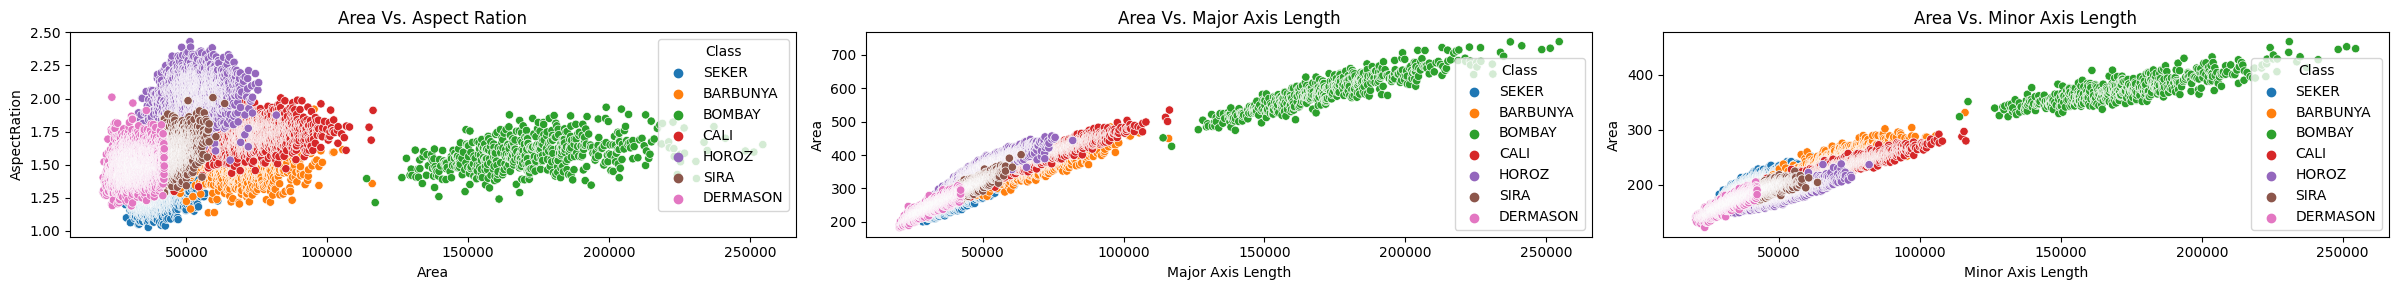

<Figure size 1000x600 with 0 Axes>

In [36]:

fig, ax = plt.subplots(1, 3, figsize=(24, 3))

# scatter plot for AspectRation vs Area
plt.figure(figsize=(10, 6))
sns.scatterplot(ax=ax[0], data=drybean_df, x='Area', y='AspectRation', hue='Class')
ax[0].set_title('Area Vs. Aspect Ration')
ax[0].set_xlabel('Area')
ax[0].set_ylabel('AspectRation')

# scatter plot for MajorAxisLength vs Area
sns.scatterplot(ax=ax[1], x='Area', y='MajorAxisLength', hue='Class', data=drybean_df)
ax[1].set_title('Area Vs. Major Axis Length')
ax[1].set_xlabel('Major Axis Length')
ax[1].set_ylabel('Area')

# scatter plot for MinorAxisLength vs Area
sns.scatterplot(ax=ax[2], x='Area', y='MinorAxisLength', hue='Class', data=drybean_df)
ax[2].set_title('Area Vs. Minor Axis Length')
ax[2].set_xlabel('Minor Axis Length')
ax[2].set_ylabel('Area')

plt.tight_layout()
plt.show()

From the three scatter plots shown above, we can see that when we plot Aspect Ration, Major Axis Length, and Minor Axis Length against Area, all three features displays good separation. We can also see that out of the three, Aspect Ration shows the greatest separation between classes, which means it is probably best at predicting the area of different beans. Furthermore, we can see that the class 'BOMBAY' is very distinguishable and could potentially use this information when we train our learners. Overall, all three features are good potential candidates for predictors of Area. We will put this to the test when we apply multilinear regression with these three features against Area and see how they perform. 

2. Multilinear Regression

In this section, we will develop our multilinear regression model to predict the Area feature with our chosen regressors. In our model, we will set X to be the regressors we chose and y to be Area. We first splits the dataset into training and testing sets, then applies k-fold cross-validation within the training set to train and evaluate the model multiple times while adjusting for parameters like PCA. The model's performance is assessed using metrics like R-squared and Mean Squared Error (MSE). After cross-validation, a final model is trained on the entire training set and evaluated on the testing set. The function also includes residual analysis, using plots to visualize the distribution of prediction errors. Through this approach, we can evaluate our chosen predictors in a robust manner.

In [63]:
def multilinear_regression_model_validation(X, y, test_size = .25, n_repeats = 50, pca = True, n_pc=3):
    
    # Splitting the data into training and testing datasets.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=12345)

    # k-fold cross-validation.
    cv = RepeatedKFold(n_splits=5, random_state=12345, n_repeats=n_repeats)
    splitting = cv.split(X=X_train, y=y_train)

    train_r2_scores = []
    test_r2_scores = []
    test_mse_scores = []

    for train_index, test_index in splitting:

        X_subtraining=X_train.iloc[train_index, :]
        X_subtesting=X_train.iloc[test_index, :]
        y_subtraining=y_train.iloc[train_index, :]
        y_subtesting=y_train.iloc[test_index, :]
        
        # Normalizing the data based on the data in the subtraining dataset.
        scaler = StandardScaler()
        scaler.fit(X_subtraining)
        X_subtraining = scaler.transform(X_subtraining)
        X_subtesting = scaler.transform(X_subtesting)

        if pca == True:
            #print("pca")
            pca_model = PCA(n_components=n_pc)
            pca_model.fit(X_subtraining) # training the PCA model
            X_subtraining = pca_model.transform(X_subtraining) # PCA transformation of the training dataset using the trained PCA model
            X_subtesting = pca_model.transform(X_subtesting)

        # Training the model using the subtraining dataset.
        lingre_model = LinearRegression()

        lingre_model.fit(X=X_subtraining, y=y_train.iloc[train_index, :])

        y_pred_test = lingre_model.predict(X_subtesting)

        train_r2 = lingre_model.score(X=X_subtraining, y=y_subtraining)
        test_r2 = lingre_model.score(X=X_subtesting, y=y_subtesting)
        test_mse = mean_squared_error(y_true=y_subtesting, y_pred=y_pred_test, squared=False)

        train_r2_scores.append(train_r2)
        test_r2_scores.append(test_r2)
        test_mse_scores.append(test_mse)

        mean_train_r2 = np.mean(train_r2_scores)
        mean_test_r2 = np.mean(test_r2_scores)
        mean_test_mse = np.mean(test_mse_scores)

    print(f"K-Fold Performance: train R-squared: {mean_train_r2}, test R-squared: {mean_test_r2}, test MSE: {mean_test_mse}")

    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    if pca == True:
        pca_model = PCA(n_components=n_pc)
        pca_model.fit(X_train) # training the PCA model
        X_train = pca_model.transform(X_train) # PCA transformation of the training dataset using the trained PCA model
        X_test = pca_model.transform(X_test)


    lingre_model = LinearRegression() 

    lingre_model.fit(X_train, y_train)
    # Evaluating the performance of the model on the subtesting dataset.
    y_pred = lingre_model.predict(X_test)
    
    residuals = (np.array(y_test)-y_pred)[:,0]

    test_R2 = lingre_model.score(X_test, y_test)

    squared_differences = (np.array(y_test) - y_pred) ** 2

    # Compute the mean of these squared differences
    mean_squared_difference = np.mean(squared_differences)

    # Take the square root of the mean
    test_RMSE = np.sqrt(mean_squared_difference)

    print(f"Final Model Performance: R^2: {test_R2}, RMSE: {test_RMSE}\n")

    plt.rcParams["figure.figsize"] = [5,1]
    plt.rcParams["figure.autolayout"] = True
    plt.tight_layout()
    sns.histplot(x=residuals, fill=True, alpha=0.2, stat='density', bins=20)
    sns.kdeplot(x=residuals, fill=True, alpha=0.2, legend=False)
    sns.kdeplot(x=np.random.normal(scale=test_mse, size=100000), fill=True, alpha=0.2, color='purple')

First test the effectiveness of all other features combined in predicting Area.

K-Fold Performance: train R-squared: 0.9512276731073269, test R-squared: 0.9511065866531867, test MSE: 6570.896207974221
Final Model Performance: R^2: 0.9528920901915936, RMSE: 6090.840299748737



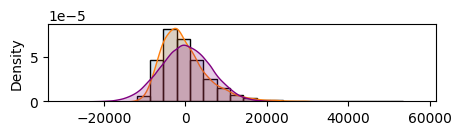

In [64]:
X = drybean_df.drop(columns=['Class', 'ConvexArea', 'EquivDiameter'])
y = drybean_df.loc[:, ['Area']]

multilinear_regression_model_validation(X, y, test_size = .25, n_repeats = 1, pca = True, n_pc=3)

Testing the effectiveness of our chosen predictors in predicting Area with PCA

K-Fold Performance: train R-squared: 0.9739139358586583, test R-squared: 0.9737679949561457, test MSE: 4808.714475340301
Final Model Performance: R^2: 0.9741453724186014, RMSE: 4512.31529770596



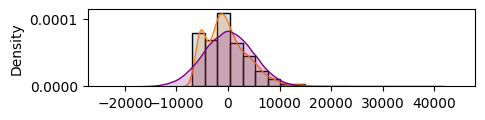

In [47]:
X = drybean_df.loc[:, ['AspectRation', 'MajorAxisLength', 'MinorAxisLength']]
y = drybean_df.loc[:, ['Area']]

multilinear_regression_model_validation(X, y, test_size = .25, n_repeats = 100, pca=True, n_pc=3)

As we can see our R Squared score is higher than the previous and our Mean Square Error and Root Mean Square Error is lower. This means our chosen predictors are effective regressors for multilinear regression for the Area feature. 

One more time without PCA

K-Fold Performance: train R-squared: 0.9739139358586583, test R-squared: 0.973767994956146, test MSE: 4808.714475340301
Final Model Performance: R^2: 0.9741453724186013, RMSE: 4512.315297705974



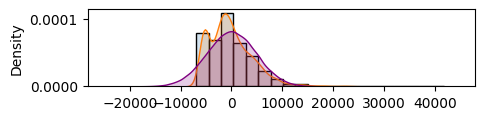

In [48]:
X = drybean_df.loc[:, ['AspectRation', 'MajorAxisLength', 'MinorAxisLength']]
y = drybean_df.loc[:, ['Area']]

multilinear_regression_model_validation(X, y, test_size = .25, n_repeats = 100, pca=False)

As we can see, the value we get when not using PCA is relatively the same as when we do use PCA. This suggests that the principal components used retain most of the information necessary for making accurate predictions. In addition, it means that PCA has successfully captured the most significant features of the data. It indicates that the variance explained by the first few principal components is sufficient for the model to perform effectively. This could imply that PCA could be a useful tool when we develop our learners for the dataset to distinguish different classes of dry beans.

3. Identifying Adequate Learner.

In this section, we will study the effectiveness of different learner models and pick one that suites well for the dataset. We will begin this process by defining our model_validation function that takes in different base models as a parameter so we can use it to test multiple learners. We will be using all the features in the dataset by default and test them against different classes. We first split the data into training and testing sets, and applying k-fold cross-validation with repeated splits to assess model performance. The function scales features, applies PCA by default, and calculates performance metrics such as accuracy, log loss, and confusion matrices during cross-validation. Post cross-validation, it retrains the model on the entire training set, evaluates it on the test set, and displays confusion matrices for both cross-validation and test evaluations. This comprehensive approach ensures a robust assessment of the model's ability to generalize and accurately classify new data.

The three learners that we will be testing are Logistic Regression, Random Forest Classification, and SVM Classifier.

Logistic regression is chosen for its ability to classify classes and provide class probabilities. Although logistic regression is fundamentally suited for binary classification problems, it can be easily extended to multiclass classification, which is useful for our purposes. 

Random Forest Classification is chosen because it is versatile and often perform well on a wide range of classification tasks, providing a good balance between accuracy and the ability to generalize to new data.

SVM Classifier is also chosen due to it's wide used in different classification tasks. It's versatility in parameter tuning can be useful especially when we try to optimize the model.

In [49]:
def model_validation(df=drybean_df, base_model=RandomForestClassifier(n_jobs=-1), 
                     selected_features='all',
                     pca=True, n_pc=10,
                     test_size=.4, n_splits=5, n_repeats=10, random_state=12345):

    if ([selected_features][0] == 'all'):
        X = df.drop(columns='Class')
    else:
        X = df.loc[:, selected_features]
    

    y = df.loc[:, ['Class']]

    # Splitting the data into training and testing datasets.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=12345)

    # k-fold cross-validation.
    cv = RepeatedKFold(n_splits=n_splits, random_state=random_state, n_repeats=n_repeats)
    splitting = cv.split(X=X_train, y=y_train)


    train_accuracies = []
    test_accuracies = []
    confusion_matrices = []
    log_loss_list = []

    for train_index, test_index in splitting:

        X_subtraining = X_train.iloc[train_index, :].copy()
        X_subtesting = X_train.iloc[test_index, :].copy()
        y_subtraining = y_train.iloc[train_index, :].copy()
        y_subtesting = y_train.iloc[test_index, :].copy()

        # Rescaling the data based on the subtraining dataset.
        scaler = StandardScaler()
        scaler.fit(X_subtraining)
        X_subtraining = scaler.transform(X_subtraining)
        X_subtesting = scaler.transform(X_subtesting)
            

        if(pca):
            pca_model = PCA(n_components=n_pc)
            pca_model.fit(X_subtraining) # training the PCA model
            X_subtraining = pca_model.fit_transform(X_subtraining) # PCA transformation of the training dataset using the trained PCA model
            X_subtesting = pca_model.transform(X_subtesting)

        # Training model based on the subtraining dataset.
        base_model.fit(X=X_subtraining, y=y_subtraining.values.ravel())
        
        # Model validation on the substesting dataset.
        y_pred = base_model.predict(X_subtesting)
        y_pred_probability = base_model.predict_proba(X_subtesting)
        
        train_accuracy = base_model.score(X=X_subtraining, y=y_subtraining)
        test_accuracy = base_model.score(X=X_subtesting, y=y_subtesting)
        log_losses = log_loss(y_true=y_subtesting, y_pred = y_pred_probability)
        test_confusion_matrix = confusion_matrix(y_true=y_subtesting, y_pred=y_pred)

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        log_loss_list.append(log_losses)
        confusion_matrices.append(test_confusion_matrix)
    
        train_accuracy = np.mean(train_accuracies)
        test_accuracy = np.mean(test_accuracies)
        log_loss_accuracy = np.mean(log_loss_list)
        conf_matrix = np.round(np.mean(confusion_matrices, axis=0), decimals=2)

    print(f"""k-fold cross-validation results: train_accuracy: {train_accuracy}, test_accuracy: {test_accuracy}, log loss: {log_loss_accuracy }""")

    # Rescaling the data based on the training dataset.
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    if(pca):
        # Applying pca transformation based on the training dataset.
        pca = PCA(n_components=n_pc)
        pca.fit(X_train)
        X_train = pca.transform(X_train)
        X_test = pca.transform(X_test)
    
    base_model.fit(X=X_train, y=y_train.values.ravel())
    y_pred = base_model.predict(X_test)
    y_pred_probability = base_model.predict_proba(X_test)
    class_names = base_model.classes_
    
    train_accuracy = base_model.score(X=X_train, y=y_train)
    test_accuracy = base_model.score(X=X_test, y=y_test)
    log_loss_accuracy = log_loss(y_true = y_test, y_pred=y_pred_probability)
    test_confusion_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
    
    print(f"""Performance on the test dataset: test_accuracy: {test_accuracy}, log loss: {log_loss_accuracy}""")

    fig, axes = plt.subplots(1, 2)
    plt.rcParams["figure.figsize"] = [5, 3]
    plt.rcParams["figure.autolayout"] = True
    ConfusionMatrixDisplay(conf_matrix, display_labels=class_names).plot(ax=axes[0], colorbar=False, cmap='rocket')
    ConfusionMatrixDisplay(test_confusion_matrix, display_labels=class_names).plot(ax=axes[1], colorbar=False, cmap='rocket')
    plt.show()

Note: For spacing purposes, the confusion matrices are not well displayed

Testing Logistic Regression

k-fold cross-validation results: train_accuracy: 0.9254837129561597, test_accuracy: 0.9227283859906931, log loss: 0.2163095590042602
Performance on the test dataset: test_accuracy: 0.9237832874196511, log loss: 0.22134564912749097


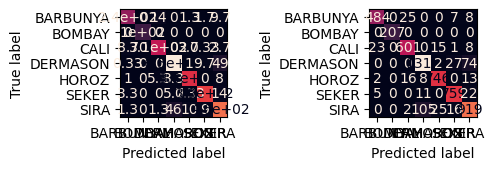

In [51]:
model_validation(test_size=.4,
                 n_repeats=1, 
                 n_splits=3, 
                 random_state=17651, 
                 base_model=LogisticRegression(n_jobs=-1, max_iter=1000))

Testing Random Forest Classification

k-fold cross-validation results: train_accuracy: 1.0, test_accuracy: 0.9240754347293656, log loss: 0.3125412225269302
Performance on the test dataset: test_accuracy: 0.9276400367309459, log loss: 0.3069191088417122


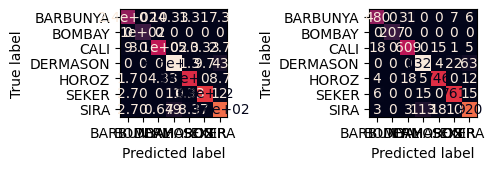

In [52]:
model_validation(test_size=.4,
                 n_repeats=1, 
                 n_splits=3, 
                 random_state=17651)

Testing SVM Classifier

k-fold cross-validation results: train_accuracy: 0.9323414156257654, test_accuracy: 0.9277492040166543, log loss: 0.1956303707875875
Performance on the test dataset: test_accuracy: 0.928374655647383, log loss: 0.199214411830166


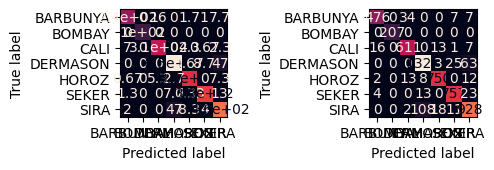

In [54]:
model_validation(test_size=.4,
                 n_repeats=1, 
                 n_splits=3, 
                 random_state=17651,
                 base_model=SVC(max_iter=10000, probability=True))

From the above testing of the three learners, we can see that they all perform decently on the dataset. This could be because the initial dataset that we are provided is well balanced and the features of different classes are distinguishable. Comparing the testing results, we can see that SVM Classifier has the highest accuracy and the lowest log loss. For this reason, we will chose SVM Classifier as the main learner we will be optimizing.

4. Learner Optimization

In this section, we will be optimizing the SVM Classifier learner. We will use various techniques such as feature engineering and parameter hypertuning. We will begin the process by identifying the top predictors for identifying classes. Then we will try to only use the top predictors as features and see if it improves our learner's performance. Then we will try parameter hypertuning by adjusting the parameter such as weight_class, Kernel, C, and gamma. Ultimately, our goal is to improve the model's performance from its evaluation results in the previous section. 

To determine what the top predictors are, we will calculates the entropy for each feature, which measures the randomness in the feature's distribution with respect to different bean classes. Lower entropy values indicate stronger association. 

In [65]:
def xlnx(x):
    indices = (x <= 0)|(x >= 1)
    x[indices] = 0
    x[~indices] = -(x[~indices]) * np.log(x[~indices])
    return x              

def feature_entropy(feature_name):
    s = drybean_df.groupby('Class')[feature_name].value_counts(normalize=True)
    entropy = s.transform(xlnx)
    return entropy.sum()

def top_predictors():
    feature_names = [col for col in drybean_df.columns if col != 'Class']
    results = pd.DataFrame({feature_name: [feature_entropy(feature_name)] for feature_name in feature_names}).T
    results.columns = ['entropy']
    return results.sort_values(by=['entropy']).head(8)
    
top_predictors()

,entropy
Area,51.576733
EquivDiameter,51.576733
ConvexArea,51.591370
Perimeter,51.981675
Solidity,52.019064
Extent,52.019162
MajorAxisLength,52.021154
MinorAxisLength,52.021154


As we can see, the top 8 predictors are displayed above. Next, we will try to run our model again with only these 8 features. This is because certain features in the dataset are not only ineffective in separating classes, but also introduce redundant noises to our model which can impair the model's performance.

k-fold cross-validation results: train_accuracy: 0.9123806024981631, test_accuracy: 0.908400685770267, log loss: 0.2432145845489528
Performance on the test dataset: test_accuracy: 0.9155188246097337, log loss: 0.2383815807541228


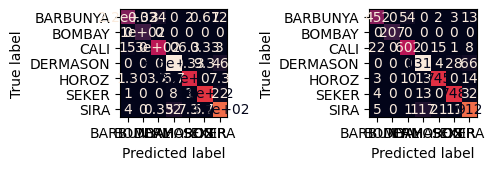

In [57]:
# selecting the top 8
selected_features=['Area', 'EquivDiameter', 'ConvexArea', 'Perimeter', 'Solidity', 'Extent',
                   'MajorAxisLength', 'MinorAxisLength']

model_validation(test_size=.4,
                 n_repeats=1, 
                 selected_features=selected_features,
                 n_pc=7,
                 n_splits=3, 
                 random_state=17651,
                 base_model=SVC(max_iter=10000, probability=True))

As we can see, the performance of the model has decreased compared to the previous section. This indicates that the top 8 predictors alone are inconclusive in identifying classes. This means we should revert back to using all features and try other approaches. 

From the confusion matrices, we can see that the the class 'BOMBAY' is easily identifiable as virtually no other classes are identifying as it and it does not identify with other classes. The two main classes that are having a hard time distinguishing from each other are 'SIRA' and 'DERMASON'. To address this issue, we will change the class weight in our model's parameter so that 'DERMASON' and 'SIRA' will get more attention and 'BOMBAY' will get less. 

Furthermore, I also experimented with different C, Kernel, and gamma and added the optimized values for those parameters that I found from testing.

k-fold cross-validation results: train_accuracy: 0.9341783002694096, test_accuracy: 0.928851334802841, log loss: 0.19543421347999623
Performance on the test dataset: test_accuracy: 0.92910927456382, log loss: 0.19865222400699856


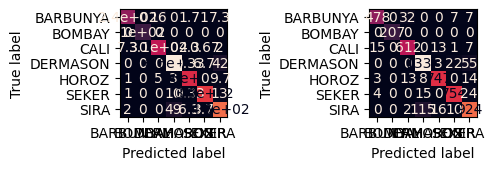

In [58]:
class_weights = {
    'DERMASON': 1.3,
    'SIRA': 1.2,
    'BOMBAY': 0.5,
    'SEKER': 1,
    'HOROZ': 1,
    'CALI': 1,
    'BARBUNYA': 1
}

model_validation(test_size=.4,
                 n_repeats=1, 
                 pca=True,
                 selected_features='all',
                 n_pc=15,
                 n_splits=3, 
                 random_state=17651,
                 base_model=SVC(max_iter=10000, class_weight=class_weights, probability=True, gamma='scale', C=1.5, kernel='rbf'))

As we can see, although we have increased the performance of our model, 0.1 percent higher accuracy and less log loss, the difference is minimal. This means that simply tuning the parameter is not enough to increase the performance of the model significantly. To do that, we need to try something else.

In data science studies, outliers can complicate datasets by skewing models and affecting decision boundaries, cluster analysis, and data balance. To mitigate this in our case, we will remove outliers using the Interquartile Range (IQR) method. Our dataset will be filtered to include only values between the first and third quantiles adjusted by 1.5 times the IQR for each feature. This approach ensures a dataset with minimized outlier influence, enhancing model reliability and accuracy.

In [59]:
def remove_outliers(df):
    for column in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Applying the function to each class
cleaned_df = drybean_df.groupby('Class').apply(lambda x: remove_outliers(x)).reset_index(drop=True)

k-fold cross-validation results: train_accuracy: 0.9536867728709519, test_accuracy: 0.9508955512372758, log loss: 0.11968256665275286
Performance on the test dataset: test_accuracy: 0.9615714899098325, log loss: 0.10030071128109092


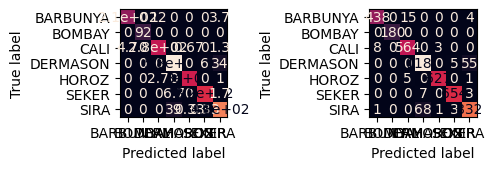

In [61]:
model_validation(df=cleaned_df,
                 test_size=.4,
                 n_repeats=1, 
                 pca=True,
                 selected_features='all',
                 n_pc=15,
                 n_splits=3, 
                 random_state=17651,
                 base_model=SVC(max_iter=10000, class_weight=class_weights, probability=True, gamma='scale', C=1.5, kernel='rbf'))

From our result, we can see that our accuracy and log loss has significantly improved. Here are the conclusions:

We improved our accuracy from the original 0.9284 to the current 0.9616. We improved our log loss from the original 0.1992 to the current 0.1004. Furthermore, the two catagories that were having a hard time distinguishing from each other has also significantly improved. 

This result shows that outliers are a very effective in convoluting a dataset especially in classification problems. For future studies and research, dealing with outliers first should be considered. However, outliers should be carefully dealt with as choosing an optimal range of data is crucial for the accuracy and performance of a model.

5. Conclusion

To sum up, in this report, we studied the dry bean dataset and developed a learner that can optimally distinguish different classes of dry beans. The inital dataset we are provided is well balanced with no missing values to fill and also showed strong correlation between features and class identification as all three of our base chosen learner performed with over 90% accuracy and below 0.25 log loss. Ultimately, we are able to optimize our chosen learner, SVM Classifier, through parameter hypertuning and eliminating outliers.

The main challenges that I faced throughout this projet is optimizing the learner. At first I though feature engineering could significanly improve the learner's performance. However, that was not the case. After analyzing the my testing results, specifically the confusion matrix, I though tuning the class weight could be crucial. However, it barely helped. It took a lot of trial and error and research for me to come to the realization that I never dealt with the outliers. Once I trimmed the dataset, the performance of the learner drasitically increased.

For future projects and improvements, experimenting with more learners and trying to optimize their performance could lead to interesting results as SVM Classifier is certainly not the only learner that is up for the task. Additionally, due to the limited computational power at my disposal, experimenting with more repeats with K-Fold Cross-Validation could also yield deeper insights. 